In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import calendar
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

rcParams['figure.figsize'] = 16,4
df = pd.read_csv('database.csv', low_memory=False)
df.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [2]:
states = df[['Year', 'Month', 'State', 'Incident']]
states = states.groupby(['Year', 'Month', 'State'], as_index=False)['Incident'].sum()
states.head()

,Year,Month,State,Incident
0,1980,April,Alabama,72
1,1980,April,Alaska,4
2,1980,April,Arizona,106
3,1980,April,Arkansas,55
4,1980,April,California,3743


In [3]:
states['Date'] = states.apply(lambda row: '{}-{}'.format(row.Year, row.Month), axis=1)
states.reset_index()
states.Date = pd.to_datetime(states.Date, format='%Y-%B')
states = states[['State', 'Incident', 'Date']]
states.head()

,State,Incident,Date
0,Alabama,72,1980-04-01
1,Alaska,4,1980-04-01
2,Arizona,106,1980-04-01
3,Arkansas,55,1980-04-01
4,California,3743,1980-04-01


In [4]:
states.Date = pd.to_datetime(states.Date, format='%Y-%B')
states.reset_index()
# states = states.sort_values(['State', 'Date'], ascending=True)
states.head()

,State,Incident,Date
0,Alabama,72,1980-04-01
1,Alaska,4,1980-04-01
2,Arizona,106,1980-04-01
3,Arkansas,55,1980-04-01
4,California,3743,1980-04-01


In [5]:
idx = pd.date_range(datetime(1980, 1, 1), datetime(2014, 12, 31), freq=pd.tseries.offsets.DateOffset(months=1))
s = pd.pivot_table(states,index=["State", "Date"], values=["Incident"], aggfunc=[np.sum])
alabama = s.query('State == ["Alabama"]')
alabama = alabama.reset_index()
alabama = alabama.set_index(pd.DatetimeIndex(alabama['Date']))
alabama = alabama[['sum']]
alabama.columns = ['Incident']
alabama = alabama.reindex(idx, fill_value=0)
alabama = alabama.fillna(0)
alabama.head()

,Incident
1980-01-01,119
1980-02-01,63
1980-03-01,103
1980-04-01,72
1980-05-01,78


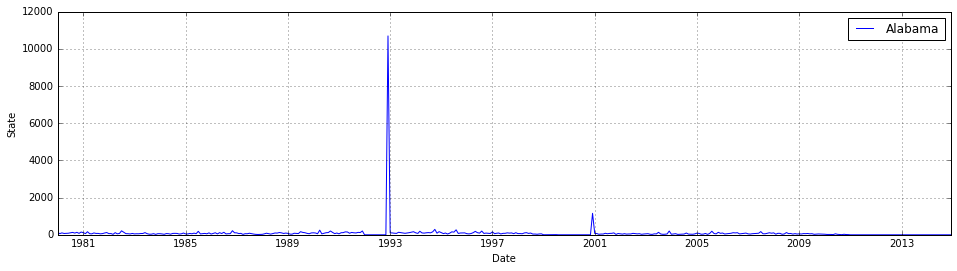

In [6]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(alabama.Incident, linestyle='-', label="{}".format('Alabama'))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

In [7]:
states_total = df[['State', 'Incident']]
states_total = states_total.groupby(['State'],as_index=False).sum()
states_total.columns = ['State', 'Incident']
states_total = states_total.sort_values(['Incident'], ascending=[True])
states_total.head()

,State,Incident
34,North Dakota,314
45,Vermont,503
41,South Dakota,556
26,Montana,640
50,Wyoming,720


In [8]:
states_list = list(states_total.State)
states_list[:5]

['North Dakota', 'Vermont', 'South Dakota', 'Montana', 'Wyoming']

In [9]:
my_series = pd.DataFrame()
s = pd.pivot_table(states,index=["State", "Date"], values=["Incident"], aggfunc=[np.sum])

for i in range(0,51):
    state = states_list[i]
    x = s.query('State == ["{}"]'.format(state))
    x = x.reset_index()
    x = x.set_index(pd.DatetimeIndex(x['Date']))
    x = x[['sum']]
    x.columns = ['Incident']
    x = x.reindex(idx, fill_value=0)
    x = x.fillna(0)
    my_series[state] = pd.Series(x['Incident'].values)
    
my_series['Alabama'].head()

0    119
1     63
2    103
3     72
4     78
Name: Alabama, dtype: int64

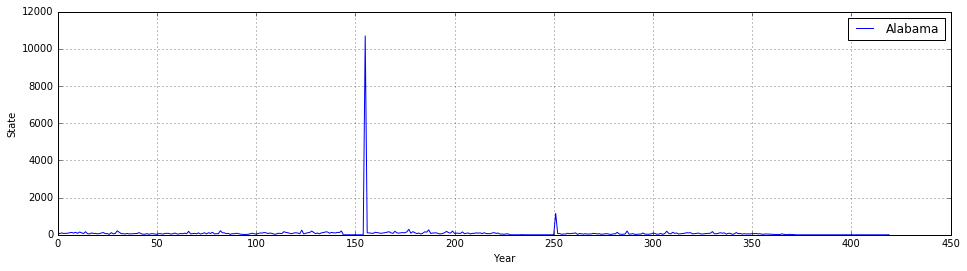

In [10]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(my_series['Alabama'], linestyle='-', label="{}".format('Alabama'))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Year')
plt.grid()
plt.show()

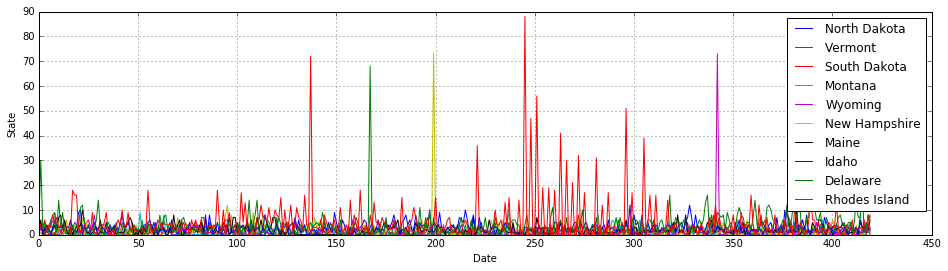

In [11]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(0,10):
    state = states_list[i]
    ax.plot(my_series[state], linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

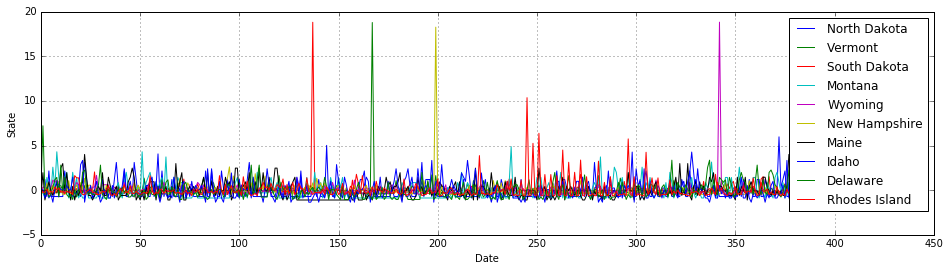

In [12]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(0,10):
    state = states_list[i]
    ax.plot((my_series[state] - my_series[state].mean())/my_series[state].std(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

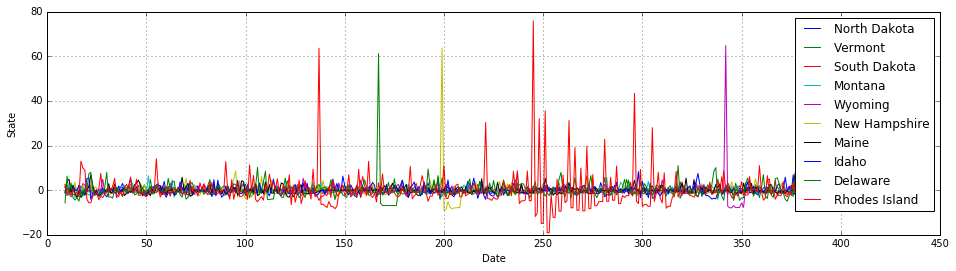

In [13]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(0,10):
    state = states_list[i]
    ax.plot(my_series[state] - my_series[state].rolling(window=10).mean(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

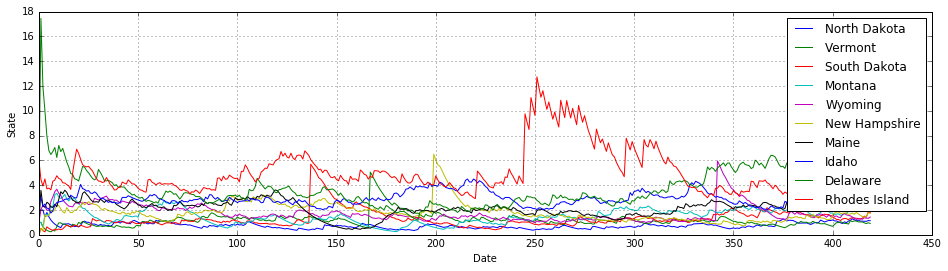

In [14]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(0,10):
    state = states_list[i]
    ax.plot(my_series[state].ewm(halflife=10).mean(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

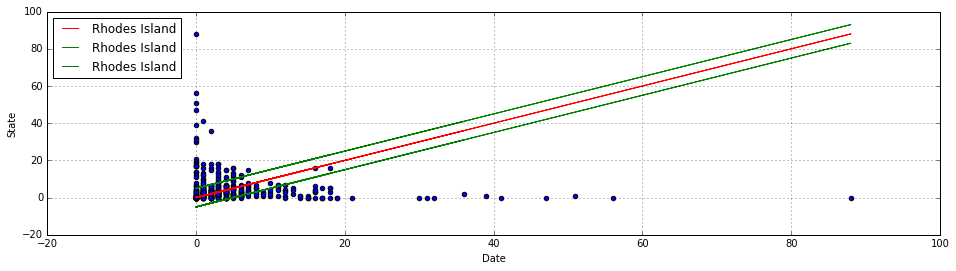

In [15]:
# Plot several state time series
from pandas.plotting import lag_plot
fig = plt.figure()
ax = plt.subplot(111)
for i in range(9,10):
    state = states_list[i]
    ts = my_series[state]
    lag_plot(ts)
    ax.plot(ts, ts, 'r-')
    ax.plot(ts, ts + 5, 'g-')
    ax.plot(ts, ts - 5, 'g-')
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

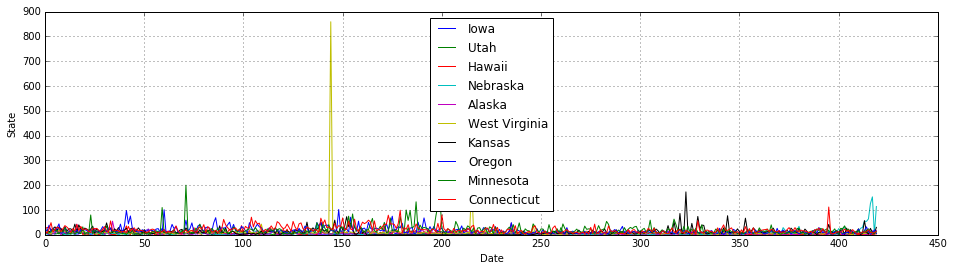

In [16]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(10,20):
    state = states_list[i]
    ax.plot(my_series[state], linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

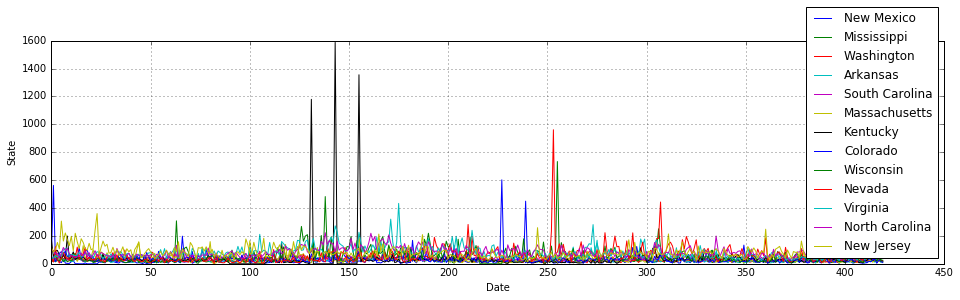

In [17]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(20,33):
    state = states_list[i]
    ax.plot(my_series[state], linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

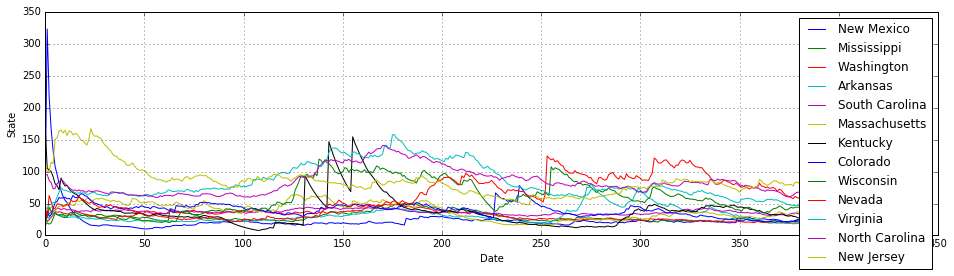

In [18]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(20,33):
    state = states_list[i]
    ax.plot(my_series[state].ewm(halflife=10).mean(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

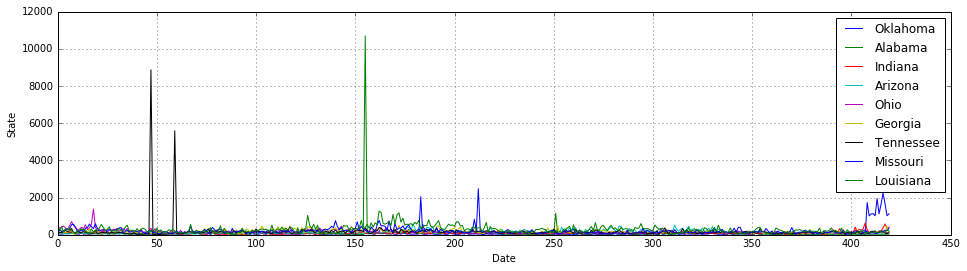

In [19]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(33,42):
    state = states_list[i]
    ax.plot(my_series[state], linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

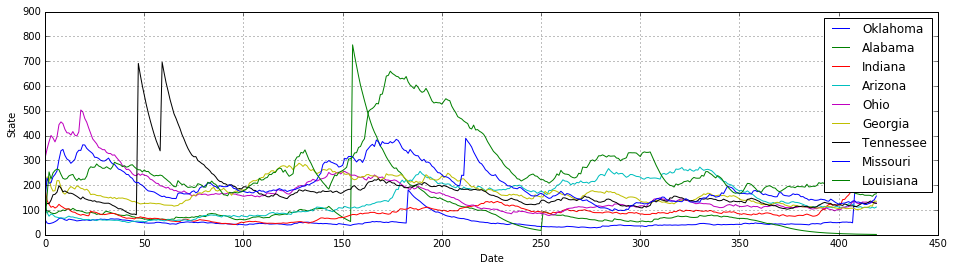

In [20]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(33,42):
    state = states_list[i]
    ax.plot(my_series[state].ewm(halflife=10).mean(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

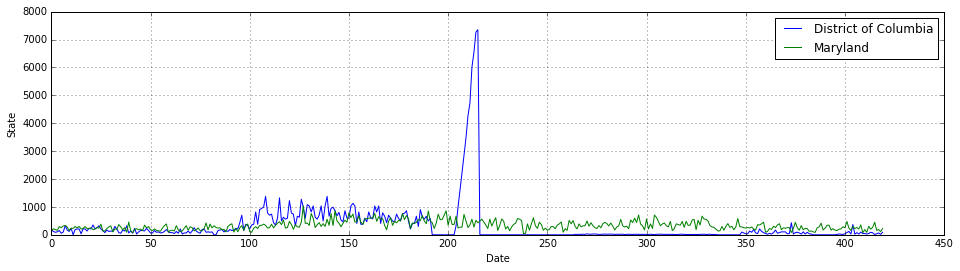

In [21]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(42,44):
    state = states_list[i]
    ax.plot(my_series[state], linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

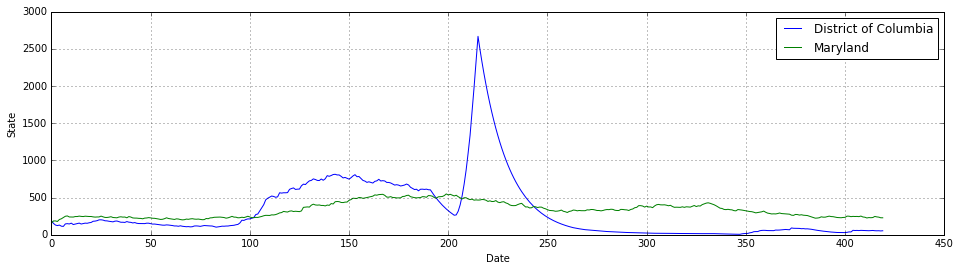

In [22]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(42,44):
    state = states_list[i]
    ax.plot(my_series[state].ewm(halflife=10).mean(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

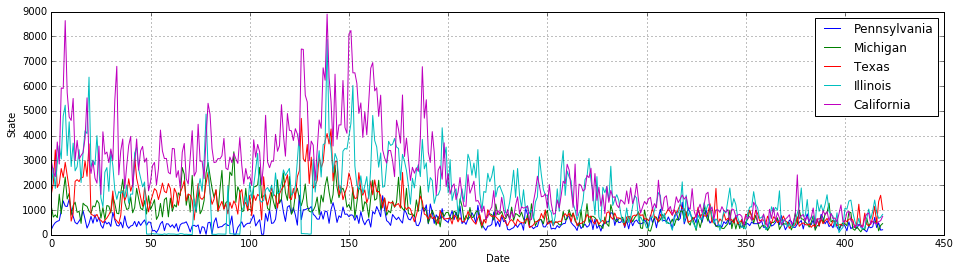

In [23]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(44,49):
    state = states_list[i]
    ax.plot(my_series[state], linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

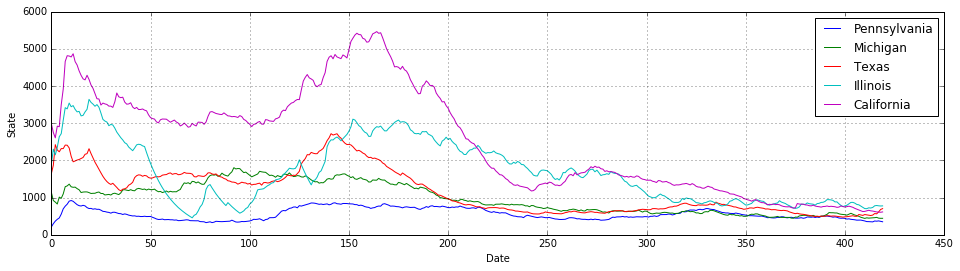

In [24]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(44,49):
    state = states_list[i]
    ax.plot(my_series[state].ewm(halflife=10).mean(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

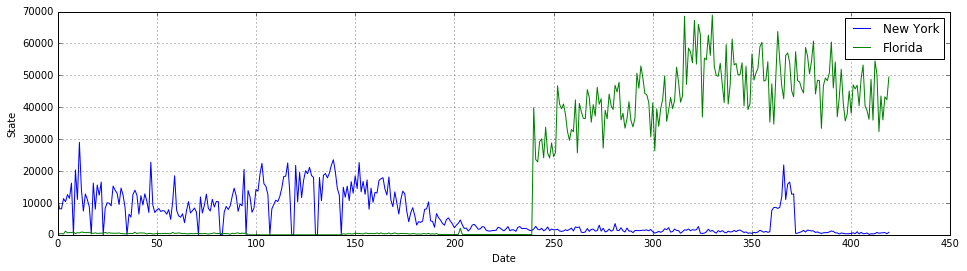

In [25]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(49,51):
    state = states_list[i]
    ax.plot(my_series[state], linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

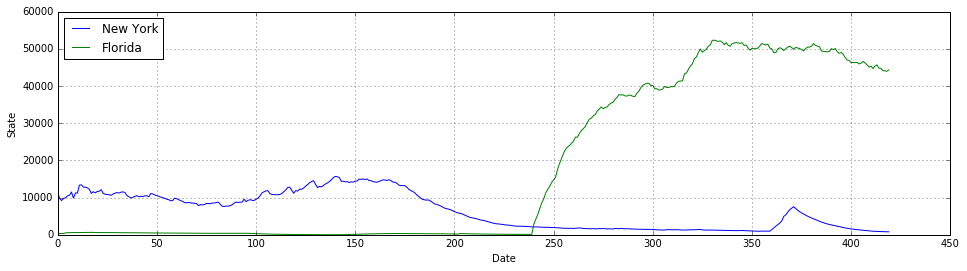

In [26]:
# Plot several state time series
fig = plt.figure()
ax = plt.subplot(111)
for i in range(49,51):
    state = states_list[i]
    ax.plot(my_series[state].ewm(halflife=10).mean(), linestyle='-', label="{}".format(state))
plt.legend(loc='best')
plt.ylabel('State')
plt.xlabel('Date')
plt.grid()
plt.show()

In [27]:
plt.matshow(my_series, interpolation=None, aspect='auto')

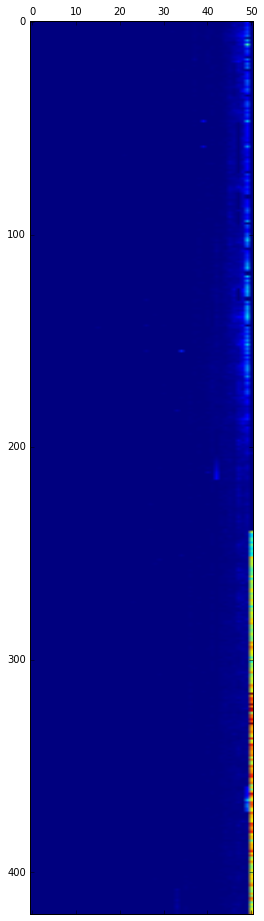

In [28]:
plt.show()

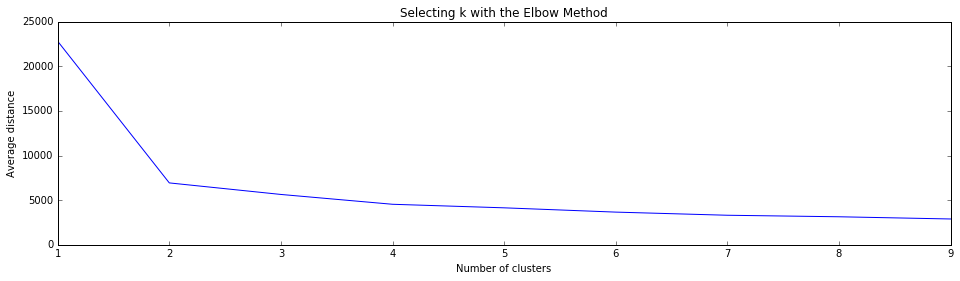

In [56]:
my_series = np.array(my_series)


# K-means cluster analysis for 1-10 clusters due to the 10 possible class outcomes for poker hands

clusters=range(1, 10)
meandist=[]

# Loop through each cluster and fit the model to the train set
# generate the predicted cluster assingment and append the mean distance my taking the sum divided by the shape

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(my_series)
    clusassign=model.predict(my_series)
    meandist.append(sum(np.min(cdist(my_series, model.cluster_centers_, 'euclidean'), axis=1))
    / my_series.shape[0])

# Choose the best cluster number with Elbow rule

"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method') # pick the fewest number of clusters that reduces the average distance
plt.show()

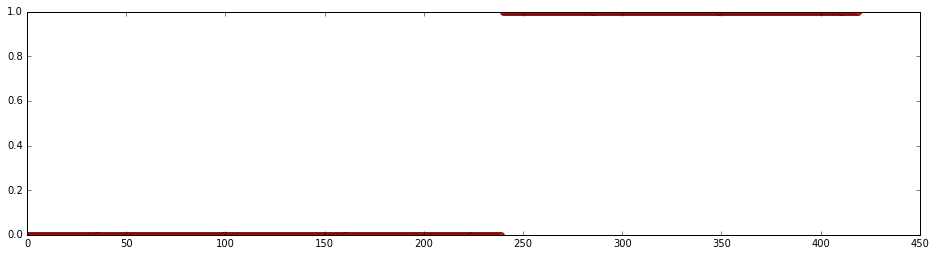

In [58]:
num_clusters = 2
km = KMeans(n_clusters=num_clusters, init='random') # k-means++ random
km.fit(my_series)
plt.plot(km.labels_, 'ro')
plt.show()

In [60]:
labels = km.predict(my_series)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [61]:
clusters = dict()
for i in range(0, num_clusters):
    clusters[i] = []

for i in range(0, 420):
    clusters[labels[i]].append(i)

clusters

{0: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
 

In [62]:
1980 + 240 / 12

2000.0